In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'pcos-detection-using-ultrasound-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2065225%2F3426692%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240328%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240328T063404Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D10955add541e9539d9cbbef0a762aa505f80be48751b021200496de91053624e89534450a19b9e44216b2fe0a89c6ee694aca2c800982bb5a9f1962a256284b5a02bf202659550186d3558ad253fefa65f913c2ba080e0630ed443990c7949b36cd1b4a6ad84eb203c08bb4780d2f4517c1c3b5ea1c1d210c8cefd1f7290dc832a271d2e7b66577c89d7caf93911ca3013c32a08422df203bd9a653c1c2558ed6fc76e1a1b75f65fc745b31a9af32ee1c2fb44e53f206c0a100a2c37881b094af3740193aecb154d1779c5062747b17e2e3601884950d74fe208292a52a779bb1f239d8396deb88632219980417f6b6683959f978f5b62a30d9b137607a508a1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 131835092 bytes downloaded
Downloaded and uncompressed: pcos-detection-using-ultrasound-images
Data source import complete.


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Input, Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
tf.keras.utils.set_random_seed(12)

batch_size = 32
img_height = img_width =224

In [ ]:
directory = "/kaggle/input/pcos-detection-using-ultrasound-images/data/train"
test = "/kaggle/input/pcos-detection-using-ultrasound-images/data/test"

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="binary",
    #class_names=None,
    shuffle=True,
    seed=12,
    validation_split= 0.15,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1924 files belonging to 2 classes.
Using 1636 files for training.


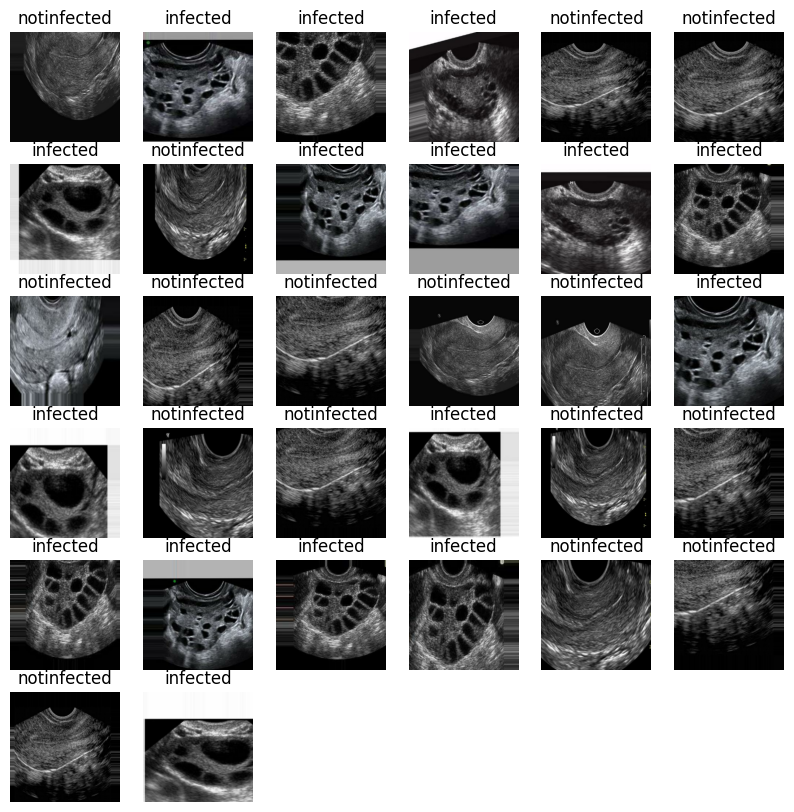

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
class_names = train_ds.class_names
for images, labels in train_ds.take(2):
    for i in range(32):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

In [ ]:
# The desired result was not achieved
"""
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="binary",
    #class_names=None,
    shuffle=True,
    seed=12,
    validation_split= 0.15,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    validation_split= 0.15,
    seed=12,
    subset="validation",
    image_size=(img_height, img_width),
    #label_mode="categorical",
    batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test,
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)
"""

# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             #width_shift_range=0.2,
                             #height_shift_range=0.2,
                             horizontal_flip = True,
                             vertical_flip=True,
                             rotation_range=20,
                             validation_split=0.2,
                             fill_mode='nearest'
                             )
# prepare an iterators for each dataset
train_ds = datagen.flow_from_directory(directory,
                                       class_mode='categorical',
                                       classes=['infected', 'notinfected'],
                                       target_size=(224, 224),
                                       batch_size=batch_size,
                                       subset='training',
                                       seed=12)
# prepare an iterators for each dataset
val_ds = datagen.flow_from_directory( directory,
                                       class_mode='categorical',
                                       classes=['infected', 'notinfected'],
                                       target_size=(224, 224),
                                       batch_size=batch_size,
                                       subset='validation',
                                       seed=12)

Found 1540 images belonging to 2 classes.
Found 384 images belonging to 2 classes.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test,
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1932 files belonging to 2 classes.


In [ ]:
model = Sequential()

model.add(Conv2D(12, (5,5),padding='SAME',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.1))

model.add(Conv2D(8, (5,5),padding='SAME',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.1))

model.add(Conv2D(4, (5,5),padding='SAME',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dense(2,activation='softmax'))

opt=Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
earlyStopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1,patience=15)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[earlyStopping],
    batch_size=batch_size,
    verbose=1,
    epochs=20)

Epoch 1/20
49/49 [==============================] - 118s 2s/step - loss: 0.5984 - accuracy: 0.7195 - val_loss: 0.4390 - val_accuracy: 0.8125
Epoch 2/20
49/49 [==============================] - 124s 3s/step - loss: 0.3008 - accuracy: 0.8682 - val_loss: 0.2211 - val_accuracy: 0.9089
Epoch 3/20
49/49 [==============================] - 116s 2s/step - loss: 0.1547 - accuracy: 0.9383 - val_loss: 0.1778 - val_accuracy: 0.9323
Epoch 4/20
49/49 [==============================] - 132s 3s/step - loss: 0.1346 - accuracy: 0.9461 - val_loss: 0.1062 - val_accuracy: 0.9557
Epoch 5/20
49/49 [==============================] - 124s 3s/step - loss: 0.0568 - accuracy: 0.9773 - val_loss: 0.0465 - val_accuracy: 0.9844
Epoch 6/20
49/49 [==============================] - 124s 3s/step - loss: 0.0262 - accuracy: 0.9922 - val_loss: 0.0155 - val_accuracy: 0.9948
Epoch 7/20
49/49 [==============================] - 123s 2s/step - loss: 0.0137 - accuracy: 0.9955 - val_loss: 0.0754 - val_accuracy: 0.9766
Epoch 8/20
49

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 12)    912       
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 12)    0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 8)     2408      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, None, None, 8)     0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 4)     804       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, None, None, 4)     0

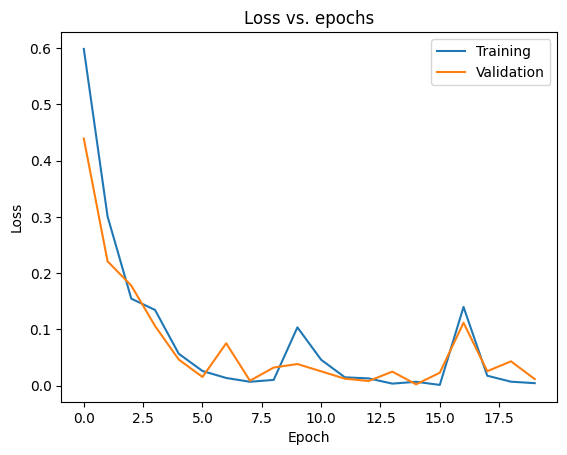

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

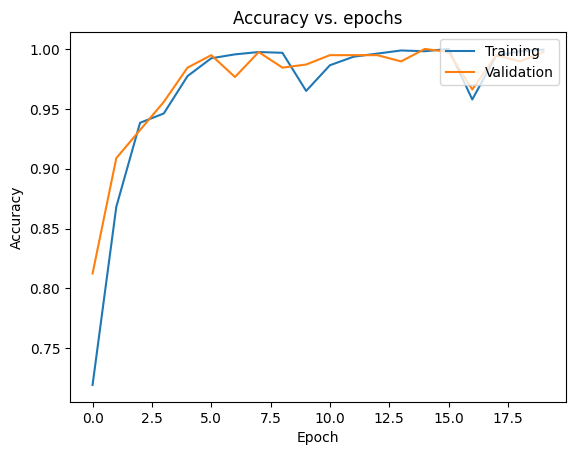

In [ ]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
model.evaluate(val_ds)

12/12 [==============================] - 12s 1s/step - loss: 0.0071 - accuracy: 0.9974


[0.007059479132294655, 0.9973958134651184]

In [ ]:
model.save('pcos.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
